In [2]:
##Imports needed plugins

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
from itertools import combinations 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import recall_score
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Import the data
data = pd.read_csv("../data/DataWithLocationCleaned.csv.gz")
df = data.copy()

In [4]:
# Add lagitude and longitude
# Create one dataFrame for persons and one only for traffic
def getlat(x):
    lat = x.partition(',')[0][1:]
    if lat[0] == "'":
        lat = lat[1:-1]
    return lat

def getlong(x):
    lat = x.partition(',')[2]
    if lat[1] == "'":
        lat = lat[2:-2]
    else:
        lat = lat[1:-1]
    return lat

df['latitude'] = df['position'].apply(lambda x: getlat(x))
df['longitude'] = df['position'].apply(lambda x: getlong(x))
persons = df[df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
traffic = df[~df['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
ports = df['Port Name'].unique()

In [5]:
def logistic(X,y,baseRate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    LR = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
    LR.fit(X_train,y_train)
    test_score = LR.score(X_test, y_test)
    train_score = LR.score(X_train,y_train)
    print("train_score :",train_score,"test_score =",test_score)
    return [train_score,test_score]

def encodeOneHot(z,f,i):
    test = z
    baseRate = pd.qcut(test['Value'],q = i, duplicates = 'drop').value_counts()
    print("Base rate :",baseRate.max()/baseRate.sum())
    print()
    test['quant'] = pd.qcut(test['Value'],q = i, duplicates = 'drop')
    print("intervalls for y:")
    print(test['quant'].value_counts())
    print()
    le = LabelEncoder()
    y = le.fit_transform(test["quant"])
    one_hot = OneHotEncoder(categories="auto")
    
    categoricals = []
    for feature in f:
        if feature in ['Measure','State','Border']:
            f.remove(feature)
            categoricals.append(feature)
            
    cat_to_onehot = one_hot.fit_transform(test[categoricals]).toarray()
    cat_to_onehot = pd.DataFrame(cat_to_onehot)
    X = pd.concat((test[f],cat_to_onehot),axis=1)
    return logistic(X,y,baseRate.max()/baseRate.sum())

def  computeLogistic(dataset,ports,f,i):
    if (len(f) == 0):
        return
    Zone = dataset[dataset['Port Name'].isin(ports)].reset_index(drop=True)
    return encodeOneHot(Zone,f,i)


In [11]:
computeLogistic(traffic,ports,['Measure','Port Code','Month','Year','State','latitude','longitude','Border'],8),

Base rate : 0.37627713578297384

intervalls for y:
(-0.001, 3.0]          87688
(9453.0, 1744349.0]    29130
(1622.0, 9453.0]       29121
(421.0, 1622.0]        29116
(74.0, 421.0]          29045
(3.0, 74.0]            28941
Name: quant, dtype: int64

train_score : 0.49283384826639204 test_score = 0.4926087236370658


([0.49283384826639204, 0.4926087236370658],)

In [ ]:
##confusion matrix
##classification report

In [36]:
computeLogistic(persons,ports,['Measure','Port Code','Month','Year','State','latitude','longitude','Border'],8),

Base rate : 0.37606668331453275

intervalls for y:
(-0.001, 11.0]          43673
(62918.0, 4447374.0]    14516
(6943.0, 62918.0]       14516
(1193.0, 6943.0]        14516
(156.0, 1193.0]         14503
(11.0, 156.0]           14407
Name: quant, dtype: int64

train_score : 0.5278028933092225 test_score = 0.5279631463383132 recall_score = 0.5279631463383132


([0.5279631463383132, 0.37606668331453275],)

The base Rate for both of these regression is too high. There is too much zero Value. 
Since the zero Value doesn't mean anyhting : Port is closed or train crossing the border isn't possible, we can just drop these values whitout changing the mean of the regression.

TO DO : EXPLAIN WHY WE TAKE ONLY NON NULL VALUES AND WHY IT DOESN'T AFFECT OUR RESULTS

In [7]:
nozero = persons[persons['Value'] != 0]
nozero.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,Year,Month,position,latitude,longitude
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Bus Passengers,63,2019,6,"(48.905266, -95.314404)",48.905266,-95.314404
3,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Personal Vehicle Passengers,7385,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882
4,Roseau,Minnesota,3426,US-Canada Border,2019-06-01,Bus Passengers,118,2019,6,"(48.7710371, -95.7697882)",48.7710371,-95.7697882


Find the best combinations of parameters in order to have the best test_score

In [15]:
computeLogistic(nozero,ports,['Measure','Port Code','Month','Year','State','latitude','longitude','Border'],8),

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.37260120001983504 test_score = 0.38300826446280994 recall_score = 0.38300826446280994


([0.38300826446280994, 0.12650745794985718],)

The Base Rate is almost perfect : ~ 1/8 = 0.125 -> So the intervals are equally balanced.

DO MULTIPLE REGRESSIONS TO FIND WHICH PARAMETER IS THE MOST INFLUENCE AND WHICH COMBINAISON IS THE BEST ONE.

In [30]:
computeLogistic(nozeroDateAsc,ports,['Measure'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.25516124233458404 test_score = 0.255404958677686 recall_score = 0.255404958677686


[0.255404958677686, 0.12650745794985718]

In [45]:
computeLogistic(nozeroDateAsc,ports,['Port Code'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.13983702209953883 test_score = 0.14386776859504133 recall_score = 0.14386776859504133


[0.14386776859504133, 0.12650745794985718]

In [31]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.2745499925618605 test_score = 0.2784793388429752 recall_score = 0.2784793388429752


[0.2784793388429752, 0.12650745794985718]

In [32]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','Month'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.2626159110067935 test_score = 0.267702479338843 recall_score = 0.267702479338843


[0.267702479338843, 0.12650745794985718]

In [33]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','Year'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.27240119671399526 test_score = 0.2769586776859504 recall_score = 0.2769586776859504


[0.2769586776859504, 0.12650745794985718]

In [40]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','State'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.3617911039851898 test_score = 0.3688595041322314 recall_score = 0.3688595041322314


[0.3688595041322314, 0.12650745794985718]

In [41]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','State','latitude'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.38306418287905586 test_score = 0.3902809917355372 recall_score = 0.3902809917355372


[0.3902809917355372, 0.12650745794985718]

In [42]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','State','latitude','longitude'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.3822873105340584 test_score = 0.39404958677685953 recall_score = 0.39404958677685953


[0.39404958677685953, 0.12650745794985718]

In [43]:
computeLogistic(nozeroDateAsc,ports,['Measure','Port Code','State','latitude','longitude','Border'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.374088827914511 test_score = 0.38320661157024793 recall_score = 0.38320661157024793


[0.38320661157024793, 0.12650745794985718]

The best combinations of parameters are ['Measure','Port Code','State','latitude','longitude']
Year and Month doesn't affect the depend variable at all. they even diminiue the train/test score.
The variable that influence the more the Value is Measure.

In [48]:
computeLogistic(nozero,ports,['Measure','Port Code','State','Year','Month','latitude','longitude'],8)

Base rate : 0.12650745794985718

intervalls for y:
(0.999, 45.0]              9567
(142958.375, 4447374.0]    9453
(32053.0, 142958.375]      9453
(7484.0, 32053.0]          9452
(740.0, 2394.0]            9452
(2394.0, 7484.0]           9451
(190.0, 740.0]             9450
(45.0, 190.0]              9346
Name: quant, dtype: int64

train_score : 0.38195672655746377 test_score = 0.39001652892561983


([0.38195672655746377, 0.39001652892561983],)

If we order by date Asc, the result are a little bit better.

In [8]:
test = []
for i in range(2,10):
    test.append([i,computeLogistic(nozero,ports,['Measure','Port Code','State','Year','Month','latitude','longitude'],i)])

Base rate : 0.5000396699460489

intervalls for y:
(0.999, 2394.0]        37815
(2394.0, 4447374.0]    37809
Name: quant, dtype: int64

train_score : 0.8178812872940049 test_score = 0.8184462809917356
Base rate : 0.3335977996403258

intervalls for y:
(0.999, 501.0]            25228
(11238.333, 4447374.0]    25208
(501.0, 11238.333]        25188
Name: quant, dtype: int64

train_score : 0.688622952445495 test_score = 0.6932231404958678
Base rate : 0.2500925632074474

intervalls for y:
(0.999, 190.0]          18913
(32053.0, 4447374.0]    18906
(2394.0, 32053.0]       18903
(190.0, 2394.0]         18902
Name: quant, dtype: int64

train_score : 0.5181573249144614 test_score = 0.5276694214876033
Base rate : 0.20034645086216016

intervalls for y:
(0.999, 103.0]          15151
(57873.4, 4447374.0]    15125
(6087.8, 57873.4]       15125
(948.0, 6087.8]         15118
(103.0, 948.0]          15105
Name: quant, dtype: int64

train_score : 0.5234466685399759 test_score = 0.5258181818181819
Base rat

In [21]:
intervalls_testError = []
for i in range(0,len(test)):
    intervalls_testError.append([test[i][0],test[i][1][0],test[i][1][1]])
print(intervalls_testError)

[[2, 0.8178812872940049, 0.8184462809917356], [3, 0.688622952445495, 0.6932231404958678], [4, 0.5181573249144614, 0.5276694214876033], [5, 0.5234466685399759, 0.5258181818181819], [6, 0.47056976148366086, 0.4715371900826446], [7, 0.40022149126431844, 0.4011900826446281], [8, 0.38195672655746377, 0.39001652892561983], [9, 0.3459561315063059, 0.34737190082644626]]


In [22]:
intervalls_testError = pd.DataFrame(intervalls_testError)
intervalls_testError

,0,1,2
0,2,0.817881,0.818446
1,3,0.688623,0.693223
2,4,0.518157,0.527669
3,5,0.523447,0.525818
4,6,0.470570,0.471537
5,7,0.400221,0.401190
6,8,0.381957,0.390017
7,9,0.345956,0.347372


In [27]:
intervalls_testError = intervalls_testError.rename(columns={0:"intervalls",1: "train_error",2:"test_error"})

In [29]:
intervalls_testError

,intervalls,train error,test error
0,2,0.817881,0.818446
1,3,0.688623,0.693223
2,4,0.518157,0.527669
3,5,0.523447,0.525818
4,6,0.470570,0.471537
5,7,0.400221,0.401190
6,8,0.381957,0.390017
7,9,0.345956,0.347372


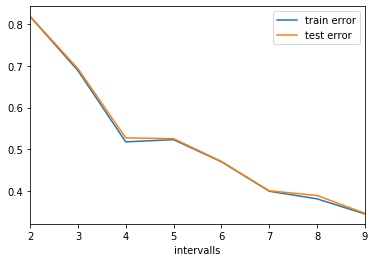

In [34]:
intervalls_testError.plot(x="intervalls", y=["train error", "test error"])

In [10]:
#We create a list of "goods" port : these port will have more than 1100 values not equal to 0.
error_port= []
for port in ports:
    if (nozero[(nozero['Port Name'] == port)].shape[0]>800):
        error_port.append([port,computeLogistic(nozero,[port],['Measure','Port Code','State','latitude','Year','Month','longitude'],8)])

Base rate : 0.12931885488647582

intervalls for y:
(0.999, 8.0]          131
(20228.5, 49762.0]    127
(1934.5, 10768.0]     127
(354.0, 477.0]        127
(10768.0, 20228.5]    126
(638.0, 1934.5]       126
(477.0, 638.0]        125
(8.0, 354.0]          124
Name: quant, dtype: int64

train_score : 0.48641975308641977 test_score = 0.458128078817734
Base rate : 0.1260115606936416

intervalls for y:
(359.999, 735.0]         109
(861514.0, 2473401.0]    108
(585881.0, 861514.0]     108
(77675.0, 585881.0]      108
(34200.0, 77675.0]       108
(12827.0, 34200.0]       108
(1002.0, 12827.0]        108
(735.0, 1002.0]          108
Name: quant, dtype: int64

train_score : 0.6315028901734104 test_score = 0.6358381502890174
Base rate : 0.12678571428571428

intervalls for y:
(81.0, 372.0]             142
(2.999, 81.0]             142
(137618.125, 307761.0]    140
(25480.0, 137618.125]     140
(4383.625, 25480.0]       140
(3293.5, 4383.625]        140
(2229.25, 3293.5]         140
(372.0, 2229.2

train_score : 0.6019955654101996 test_score = 0.6017699115044248
Base rate : 0.1259351620947631

intervalls for y:
(90625.0, 156527.0]     101
(0.999, 134.125]        101
(45115.75, 90625.0]     100
(10645.25, 45115.75]    100
(3269.0, 10645.25]      100
(758.125, 3269.0]       100
(279.25, 758.125]       100
(134.125, 279.25]       100
Name: quant, dtype: int64

train_score : 0.2792511700468019 test_score = 0.2546583850931677
Base rate : 0.12546125461254612

intervalls for y:
(73589.0, 148151.0]    102
(25006.5, 51023.0]     102
(14652.0, 20260.0]     102
(1214.0, 1840.0]       102
(9.999, 1214.0]        102
(51023.0, 73589.0]     101
(20260.0, 25006.5]     101
(1840.0, 14652.0]      101
Name: quant, dtype: int64

train_score : 0.4676923076923077 test_score = 0.4233128834355828
Base rate : 0.1276595744680851

intervalls for y:
(416.25, 483.0]         144
(15113.875, 41536.0]    141
(3515.25, 15113.875]    141
(795.875, 3515.25]      141
(577.0, 795.875]        141
(304.875, 416.25]   

train_score : 0.5577777777777778 test_score = 0.6044444444444445
Base rate : 0.12771084337349398

intervalls for y:
(0.999, 28.0]           106
(135.875, 287.0]        105
(22522.75, 59961.0]     104
(14275.75, 22522.75]    104
(842.0, 14275.75]       103
(287.0, 842.0]          103
(28.0, 71.0]            103
(71.0, 135.875]         102
Name: quant, dtype: int64

train_score : 0.40813253012048195 test_score = 0.39156626506024095


In [11]:
error_port

[['Warroad', [0.48641975308641977, 0.458128078817734]],
 ['Detroit', [0.6315028901734104, 0.6358381502890174]],
 ['Sumas', [0.5334821428571429, 0.6383928571428571]],
 ['Point Roberts', [0.30781010719754975, 0.2865853658536585]],
 ['Oroville', [0.5694864048338368, 0.5060240963855421]],
 ['Laurier', [0.514030612244898, 0.5380710659898477]],
 ['Frontier', [0.5296735905044511, 0.47928994082840237]],
 ['Blaine', [0.49742268041237114, 0.4587628865979381]],
 ['Richford', [0.3220108695652174, 0.375]],
 ['Norton', [0.47925033467202144, 0.40106951871657753]],
 ['Highgate Springs-Alburg', [0.3981358189081225, 0.35638297872340424]],
 ['Derby Line', [0.4427934621099554, 0.40236686390532544]],
 ['Roma', [0.55096011816839, 0.5588235294117647]],
 ['Presidio', [0.5182584269662921, 0.48314606741573035]],
 ['Laredo', [0.4526627218934911, 0.4911242603550296]],
 ['Hidalgo', [0.5562130177514792, 0.5058823529411764]],
 ['El Paso', [0.6735941320293398, 0.6829268292682927]],
 ['Eagle Pass', [0.5205992509363296

In [17]:
port_localisation = []
for i in range(0,len(error_port)):
    port_localisation.append([error_port[i][0],error_port[i][1][0],error_port[i][1][1]])

In [18]:
port_localisation

[['Warroad', 0.48641975308641977, 0.458128078817734],
 ['Detroit', 0.6315028901734104, 0.6358381502890174],
 ['Sumas', 0.5334821428571429, 0.6383928571428571],
 ['Point Roberts', 0.30781010719754975, 0.2865853658536585],
 ['Oroville', 0.5694864048338368, 0.5060240963855421],
 ['Laurier', 0.514030612244898, 0.5380710659898477],
 ['Frontier', 0.5296735905044511, 0.47928994082840237],
 ['Blaine', 0.49742268041237114, 0.4587628865979381],
 ['Richford', 0.3220108695652174, 0.375],
 ['Norton', 0.47925033467202144, 0.40106951871657753],
 ['Highgate Springs-Alburg', 0.3981358189081225, 0.35638297872340424],
 ['Derby Line', 0.4427934621099554, 0.40236686390532544],
 ['Roma', 0.55096011816839, 0.5588235294117647],
 ['Presidio', 0.5182584269662921, 0.48314606741573035],
 ['Laredo', 0.4526627218934911, 0.4911242603550296],
 ['Hidalgo', 0.5562130177514792, 0.5058823529411764],
 ['El Paso', 0.6735941320293398, 0.6829268292682927],
 ['Eagle Pass', 0.5205992509363296, 0.4626865671641791],
 ['Brownsvil

In [ ]:
ps = persons[['Port Name','latitude']].drop_duplicates().set_index('Port Name')
best['latitude'] = best['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
ps = persons[['Port Name','longitude']].drop_duplicates().set_index('Port Name')
best['longitude'] = best['Port Name'].apply(lambda x : ', '.join(ps.loc[x].values.flatten()))
best['text'] = best['Port Name'] + '<br>Test Score: ' + (best['Test Score']).astype(str)

color = "crimson"
scale = 700
    

fig = go.Figure()
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = best['longitude'],
    lat = best['latitude'],
    text = best['text'],
    marker = dict(
        size = (best['Test Score']/best['Test Score'].max())*scale,
        color = color, ##percentages
        line_color='rgb(20,20,20)',
        line_width=0.5,
        sizemode = 'area')))

fig.update_layout(
        title_text = 'US Borders, total inbound persons since 1996<br>(Click legend to toggle traces)',
        showlegend = False,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

TO DO : Matrice de corrélation entre les facteurs

TO DO : Graphique importante des facteurs

# Linear Regression

TO DO : Create a linear regression with the logValue for y. (see notebook linear_regression)